# GNN Scaling Analysis

In [7]:
import os
import sys
import pickle
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Local imports
sys.path.append('..')
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [5]:
%matplotlib inline

In [51]:
plt.rcParams.update({'font.size': 14})

In [18]:
def load_result(result_dir):
    history_files = glob.glob(os.path.join(result_dir, 'summaries_*.csv'))
    return pd.concat([pd.read_csv(f) for f in history_files], ignore_index=True)

def compute_mean_time(r):
    return r[r.epoch>0].train_time.mean()

def get_num_samples(config):
    return config['data']['n_train']

def compute_throughput(result, config):
    return get_num_samples(config) / compute_mean_time(result)

In [8]:
ls $SCRATCH/heptrkx/results

RNNFilter_20180207_1121/  agnn_wd_000/         mpnn_med_001/
agnn_000/                 agnn_wd_001/         mpnn_test/
agnn_001/                 agnn_xavier/         nragnn_000/
agnn_002/                 gnnsparse_big_001/   nragnn_001/
agnn_002_8gpu/            gnnsparse_med_001/   nrmpnn_000/
agnn_003/                 hpotest/             nrmpnn_001/
agnn_004/                 mpnn_001/            pbt_20191004-092629/
agnn_005/                 mpnn_002/            pbt_20191004_111252/
agnn_006/                 mpnn_007/            pbt_20191004_111702/
agnn_007/                 mpnn_008/            pbt_20191004_112424/
agnn_008/                 mpnn_big_000/        pbt_20191004_131346/
agnn_009/                 mpnn_big_001/        pbt_20191004_131558/
agnn_big_000/             mpnn_big_002/        resagnn_000/
agnn_big_001/             mpnn_big_003/        resmpnn_001/
agnn_big_002/             mpnn_big_004/        resmpnn_002/
agnn_hpo_525312_0/        mpnn_big_005/        resmpnn_00

## Cori Scaling

In [9]:
cori_result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_*'))
cori_result_dirs

['/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n16',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n32',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n4',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n64',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_agnn_n8']

In [21]:
cori_configs = [load_config_dir(d) for d in cori_result_dirs]
cori_results = [load_result(d) for d in cori_result_dirs]

In [28]:
cori_results[0]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.708037,2704.339440,26.295183,0,21.179651,0.421727,0.833089,5.877067
1,0.001,0.688048,2705.956809,26.293282,1,19.320132,0.340909,0.908189,5.051546
2,0.001,0.680002,2706.512194,26.285270,2,18.846067,0.370565,0.878614,5.205353
3,0.001,0.676877,2707.337113,26.279203,3,18.489243,0.351578,0.888773,4.874655


In [30]:
# Compute throughputs
ranks = np.array([c['n_ranks'] for c in cori_configs])
throughputs = np.array([compute_throughput(r, c) for (r, c) in zip(cori_results, cori_configs)])
idx = np.argsort(ranks)
ranks = ranks[idx]
throughputs = throughputs[idx]

Text(0, 0.5, 'Throughput')

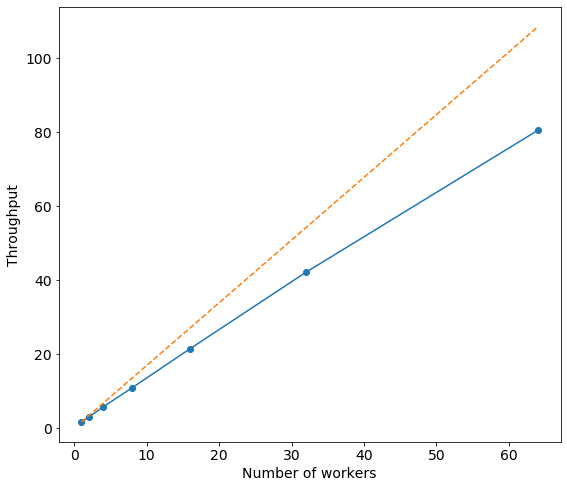

In [55]:
plt.figure(figsize=(9, 8))
plt.plot(ranks, throughputs, 'o-', label='Training')
plt.plot(ranks, ranks*throughputs[0], '--', label='Ideal')
plt.xlabel('Number of workers')
plt.ylabel('Throughput');

## Cori GPU scaling

In [63]:
cgpu_result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_*'))
cgpu_result_dirs

['/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n16',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n32',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n4',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n64',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/scaling_cgpu_agnn_n8']

In [64]:
cgpu_configs = [load_config_dir(d) for d in cgpu_result_dirs]
cgpu_results = [load_result(d) for d in cgpu_result_dirs]

In [65]:
cgpu_results[0]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.678537,2719.685743,26.376312,0,13.921123,0.351072,0.884437,2.829564
1,0.001,0.638763,2760.239212,26.575935,1,13.610343,0.325373,0.896523,2.828546
2,0.001,0.576113,2821.214641,26.888685,2,13.587891,0.268393,0.867234,2.816015
3,0.001,0.447980,2861.069703,27.106458,3,13.558922,0.223351,0.885795,2.795503


In [66]:
# Compute throughputs
ranks = np.array([c['n_ranks'] for c in cgpu_configs])
throughputs = np.array([compute_throughput(r, c) for (r, c) in zip(cgpu_results, cgpu_configs)])
idx = np.argsort(ranks)
ranks = ranks[idx]
throughputs = throughputs[idx]

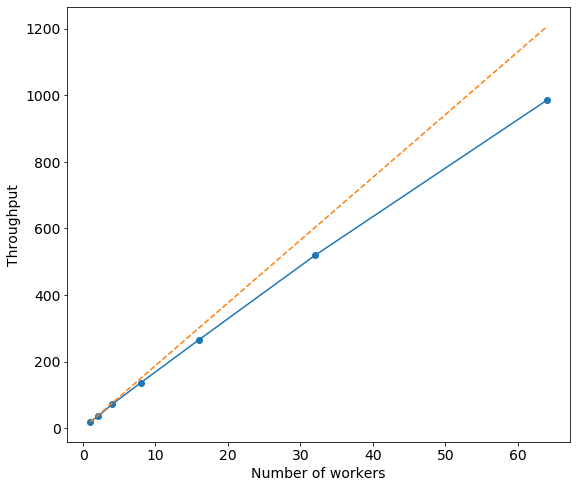

In [67]:
plt.figure(figsize=(9, 8))
plt.plot(ranks, throughputs, 'o-', label='Training')
plt.plot(ranks, ranks*throughputs[0], '--', label='Ideal')
plt.xlabel('Number of workers')
plt.ylabel('Throughput');